# Homework 1

This homework will cover convolutions and Canny edge detectors.

*This homework was adapted from Stanford CS131*


In [38]:
import os

if not os.path.exists("CS485_584"):
    # Clone the repository if it doesn't already exist
    !git clone https://github.com/YoungjoongEmory/CS485_584.git

Cloning into 'CS485_584'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 81 (delta 12), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 6.31 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [39]:
cd CS485_584/Assignments/HW1/

/content/CS485_584/Assignments/HW1/CS485_584/Assignments/HW1


## Setup

In [40]:
# Install the necessary dependencies
# (restart your runtime session if prompted to, and then re-run this cell)

!pip install -r requirements.txt

In [41]:
# Setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

----
## Part 1: Convolutions (20 points)

In this section, you will implement convolution:
- `conv_fast`

First, run the code cell below to load the image to work with.

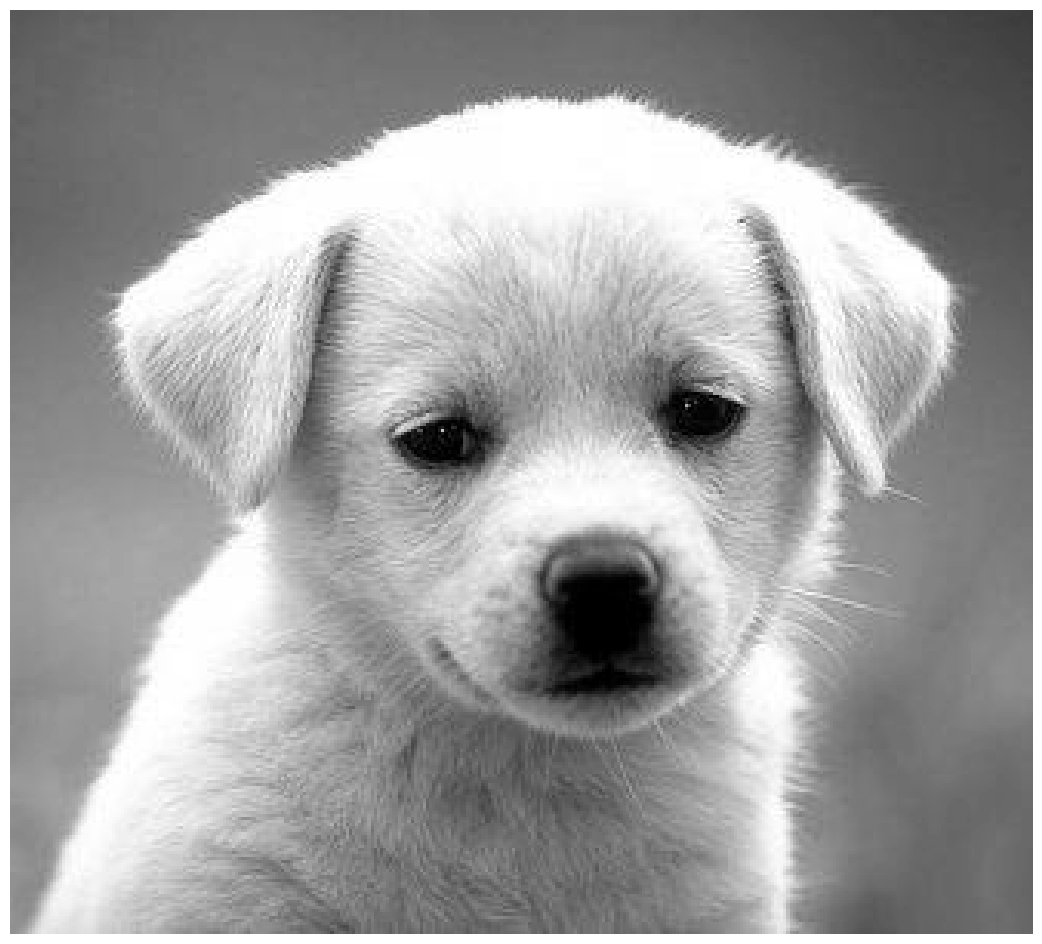

In [42]:
# Open image as grayscale
img = io.imread('dog.jpg', as_gray=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

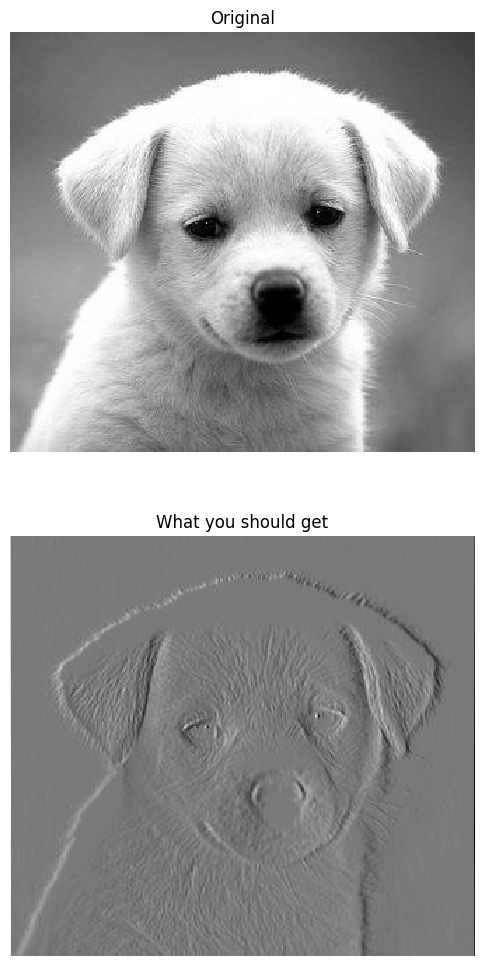

In [43]:

# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')


# Plot what you should get
solution_img = io.imread('convolved_dog.png', as_gray=True)
plt.subplot(2,2,3)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Let us implement efficient convolution using array operations in numpy. A convolution can be considered as a sliding window that computes sum of the pixel values weighted by the flipped kernel. The faster version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute weighted sum of the neighborhood at each pixel.

First, implement the function **`zero_pad`** below.


In [44]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    H, W = image.shape
    out = np.zeros((H+2*pad_height, W+2*pad_width))
    out[pad_height:pad_height+H, pad_width:pad_width+W] = image

    ### END YOUR CODE
    return out



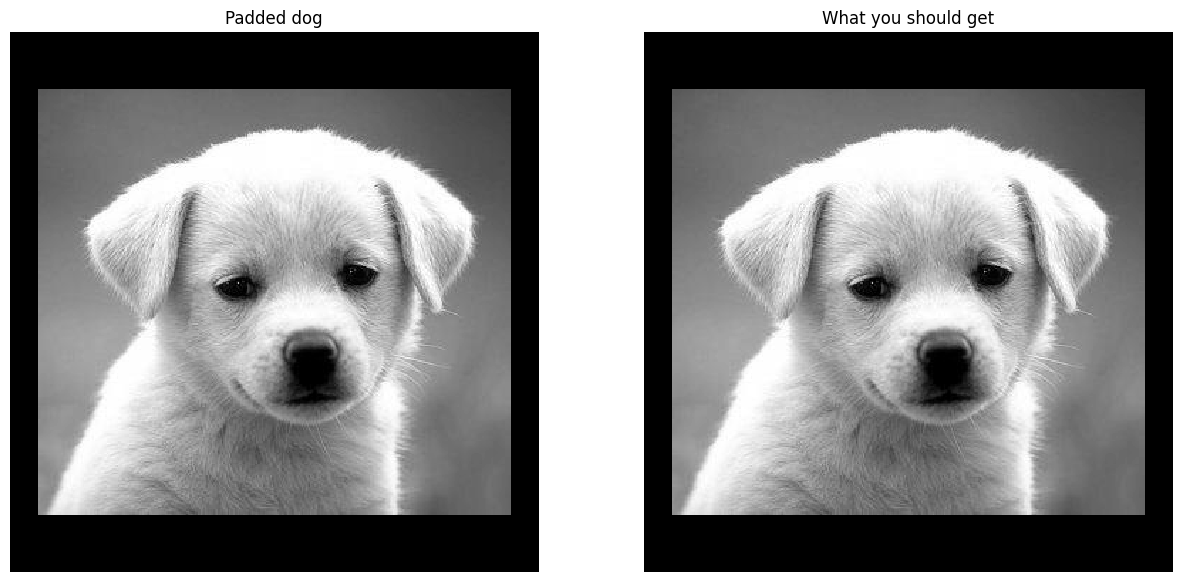

In [45]:

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('padded_dog.jpg', as_gray=True)
plt.subplot(1,2,2)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Next, complete the function **`conv_fast`** below using `zero_pad`.
It would be easier to iterate over the output image (out) and map to padded image.


In [46]:
def conv_fast(image, kernel):
    """ An efficient implementation of convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    Hints:
        - Use the zero_pad function you implemented above
        - There should be two nested for-loops
        - You may find np.flip() and np.sum() useful

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk). Dimensions will be odd.

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    ### YOUR CODE HERE
    padded = zero_pad(image, Hk//2, Wk//2)
    for i in range(Hi):
        for j in range(Wi):
            # Flip kernel both directions
            out[i,j] = np.sum(padded[i:i+Hk, j:j+Wk] * np.flip(kernel,(0,1)))

    ### END YOUR CODE

    return out

conv_fast: took 1.325186 seconds.


(np.float64(-0.5), np.float64(331.5), np.float64(299.5), np.float64(-0.5))

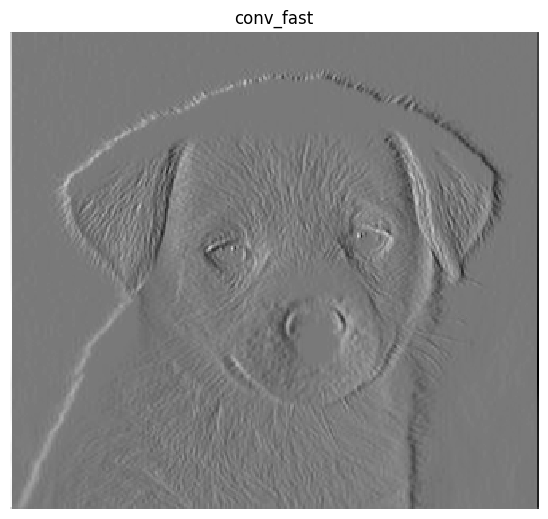

In [47]:

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()

print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')


---
## Part 3: Canny Edge Detector (80 points)
In this part, you are going to implement a Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 3.1 Smoothing (10 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** and run the code below.

In [48]:
def gaussian_kernel(size, sigma):
    """ Implementation of Gaussian Kernel.

    This function follows the gaussian kernel formula,
    and creates a kernel matrix.

    Hints:
    - Use np.pi and np.exp to compute pi and exp.

    Args:
        size: int of the size of output matrix.
        sigma: float of sigma to calculate kernel.

    Returns:
        kernel: numpy array of shape (size, size).
    """

    kernel = np.zeros((size, size))

    ### YOUR CODE HERE
    for i in range(size):
        for j in range(size):
            # Assuming `size` is 2k+1, k would be (2k+1) div 2
            kernel[i,j] = 1/(2*np.pi*sigma**2)*np.exp(-((i-size//2)**2+(j-size//2)**2)/(2*sigma**2))

    ### END YOUR CODE

    return kernel

In [49]:
# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

Implement **`conv`** and run the code below. This time, ensure that you're using **edge** padding (as opposed to zero-padding, as done in `conv_fast`).

Hint: Check out `np.pad`, and the various `mode`s that it takes.

In [50]:
def conv(image, kernel):
    """ An implementation of convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape

    out = np.zeros((Hi, Wi),dtype=np.float32)

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_height = Hk//2
    pad_width = Wk//2
    padded = np.pad(image.astype(np.float32), ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')

    ### YOUR CODE HERE
    for i in range(Hi):
        for j in range(Wi):
            out[i,j] = np.sum(padded[i:i+Hk, j:j+Wk] * kernel)

    ### END YOUR CODE

    return out

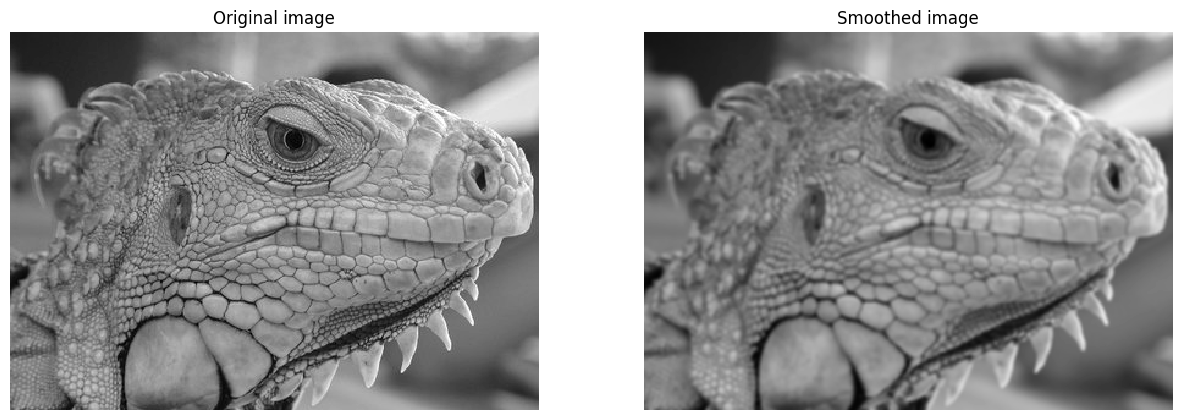

In [51]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

### 3.2 Finding gradients (10 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined below.

*-Hint: Remeber that convolution flips the kernel.*

In [52]:

def partial_x(img):
    """ Computes partial x-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.
        - The kernel shape should be (1,3)

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: x-derivative image.
    """

    out = None

    ### YOUR CODE HERE
    kernel = 0.5 * np.array([[-1,0,1]])
    out = conv(img, kernel)



    ### END YOUR CODE

    return out

def partial_y(img):
    """ Computes partial y-derivative of input img.

    Hints:
        - You may use the conv function in defined in this file.
        - The kernel shape should be (3,1)

    Args:
        img: numpy array of shape (H, W).
    Returns:
        out: y-derivative image.
    """

    out = None

    ### YOUR CODE HERE
    kernel = 0.5 * np.array([[-1],[0],[1]])
    out = conv(img, kernel)

    ### END YOUR CODE

    return out


In [53]:
# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)
print(I_x)
print(I_y)
# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')

if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

[[ 0.   0.   0. ]
 [ 0.5  0.  -0.5]
 [ 0.   0.   0. ]]
[[ 0.   0.5  0. ]
 [ 0.   0.   0. ]
 [ 0.  -0.5  0. ]]


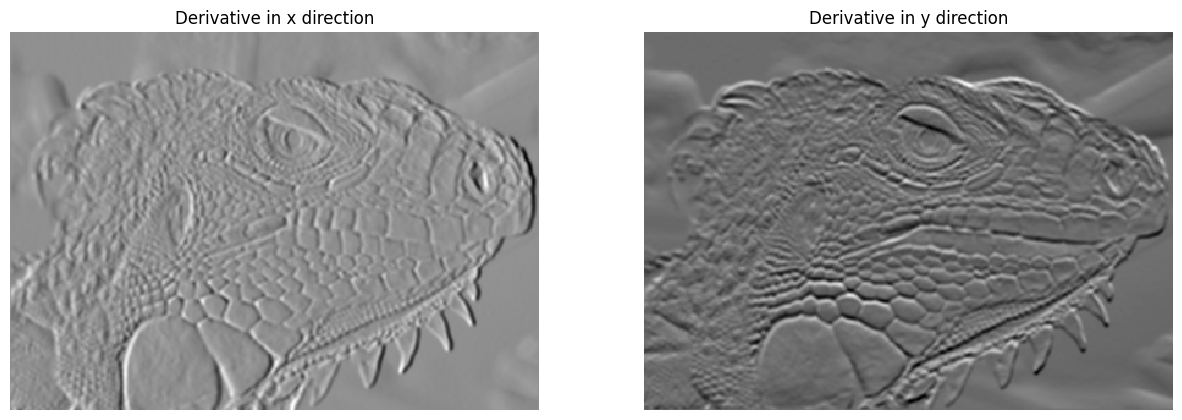

In [54]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** below which takes in an image and outputs $G$ and $\Theta$.

In [55]:

def gradient(img):
    """ Returns gradient magnitude and direction of input img.

    Args:
        img: Grayscale image. Numpy array of shape (H, W).

    Returns:
        G: Magnitude of gradient at each pixel in img.
            Numpy array of shape (H, W).
        theta: Direction(in degrees, 0 <= theta < 360) of gradient
            at each pixel in img. Numpy array of shape (H, W).

    Hints:
        - Use np.sqrt and np.arctan2 to calculate square root and arctan
    """
    G = np.zeros(img.shape)
    theta = np.zeros(img.shape)

    ### YOUR CODE HERE
    Gx = partial_x(img)
    Gy = partial_y(img)
    G = np.sqrt(Gx**2 + Gy**2)
    theta = np.arctan2(Gy, Gx) * 180 / np.pi

    # Turn negative angles to positive ones
    theta[theta < 0] += 360

    ### END YOUR CODE

    return G, theta


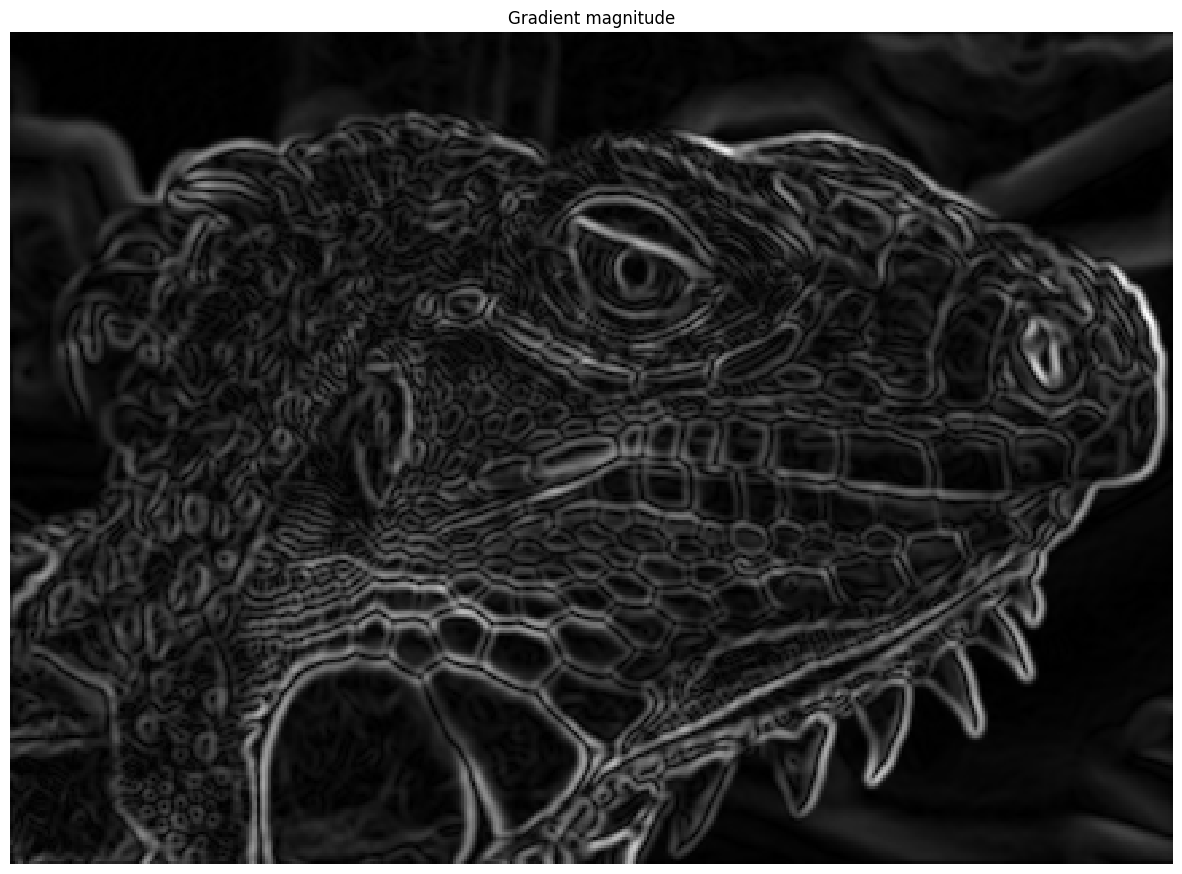

In [56]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')

if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 3.3 Non-maximum suppression (20 points)
You should be able to see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`** below.

In [57]:

def non_maximum_suppression(G, theta: np.array):
    """ Performs non-maximum suppression.

    This function performs non-maximum suppression along the direction
    of gradient (theta) on the gradient magnitude image (G).

    Args:
        G: gradient magnitude image with shape of (H, W).
        theta: direction of gradients with shape of (H, W).

    Returns:
        out: non-maxima suppressed image.
    """
    H, W = G.shape
    out = np.zeros((H, W))

    # Round the gradient direction to the nearest 45 degrees
    theta_rounded = np.floor((theta + 22.5) / 45) * 45
    theta_rounded = theta_rounded.astype(int)
    theta_rounded[theta_rounded < 0] += 360
    theta_rounded[theta_rounded >= 360] -= 360


    #print(G)
    ### BEGIN YOUR CODE

    def compare_neighbors(i, j, theta_rounded):
        # Compare the correct neighbor in the gradient direction, checking for out of bounds as well
        if i <= 0 or i >= H-1 or j <= 0 or j >= W-1:
            return 0

        cur = G[i, j]

        if theta_rounded in [0, 180]:
            neighbors = [(i, j-1), (i, j+1)]
        elif theta_rounded in [45, 225]:
            neighbors = [(i-1, j+1), (i+1, j-1)]
        elif theta_rounded in [90, 270]:
            neighbors = [(i-1, j), (i+1, j)]
        elif theta_rounded in [135, 315]:
            neighbors = [(i+1, j+1), (i-1, j-1)]
        else:
            raise RuntimeError("Something went wrong, check here")

        for coord in neighbors:
            if G[coord[0], coord[1]] > cur:
                return 0
        return cur


    for i in range(H):
        for j in range(W):
            out[i,j] = compare_neighbors(i, j, theta_rounded[i,j])


    ### END YOUR CODE

    return out




In [58]:
# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    #print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0. ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


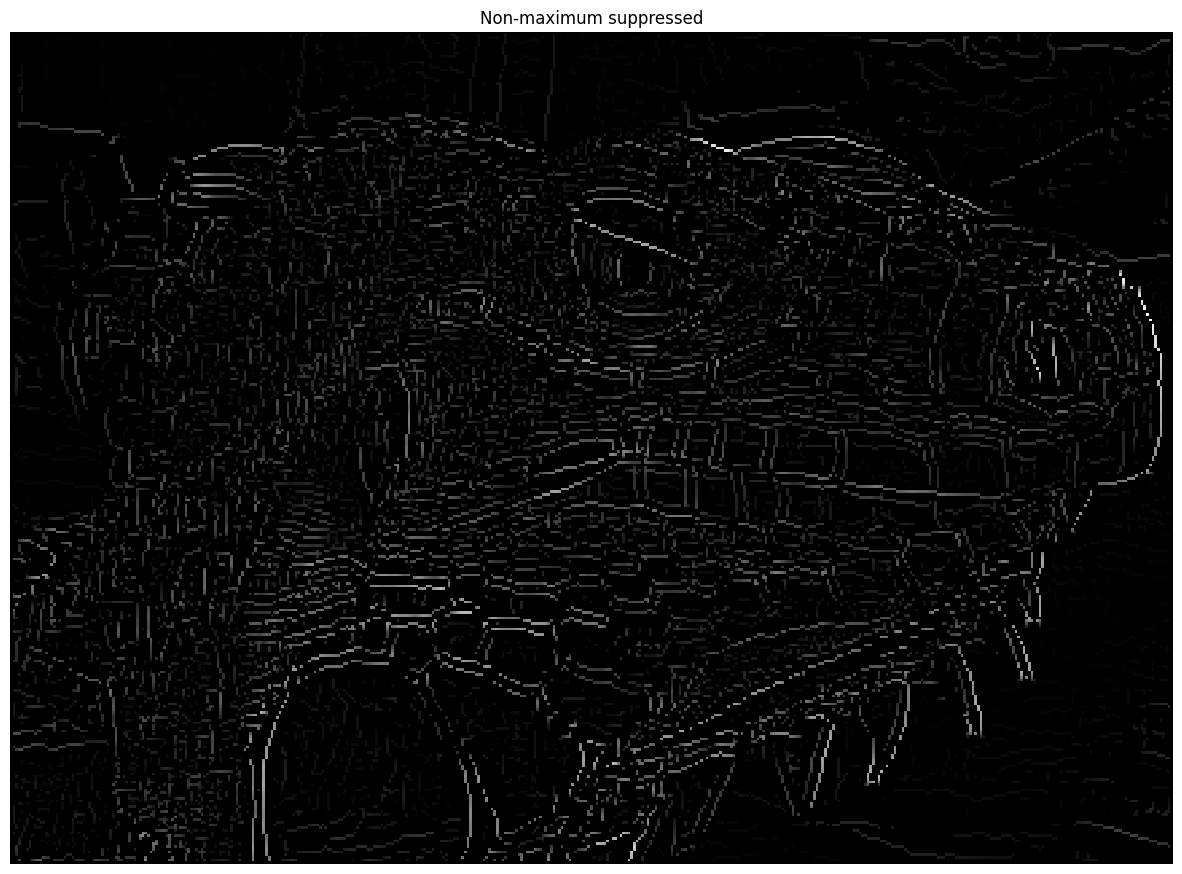

In [59]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

### 3.4 Double Thresholding (20 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`** below.

In [60]:
def double_thresholding(img, high, low):
    """
    Args:
        img: numpy array of shape (H, W) representing NMS edge response.
        high: high threshold(float) for strong edges.
        low: low threshold(float) for weak edges.

    Returns:
        strong_edges: Boolean array representing strong edges.
            Strong edeges are the pixels with the values greater than
            the higher threshold.
        weak_edges: Boolean array representing weak edges.
            Weak edges are the pixels with the values smaller or equal to the
            higher threshold and greater than the lower threshold.
    """

    strong_edges = np.zeros(img.shape, dtype=bool)
    weak_edges = np.zeros(img.shape, dtype=bool)

    ### YOUR CODE HERE
    strong_edges = img > high
    weak_edges = (img <= high) & (img > low)

    ### END YOUR CODE

    return strong_edges, weak_edges


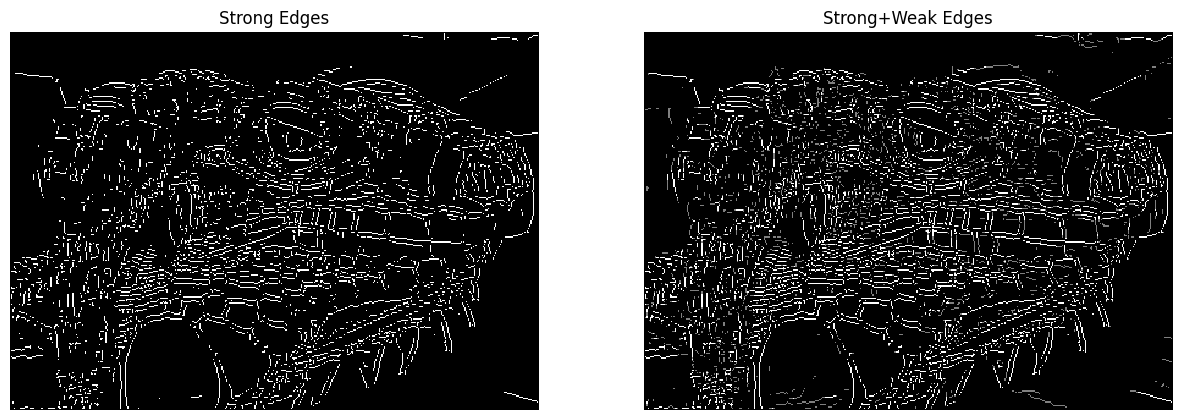

In [61]:

low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 3.5 Edge tracking (20 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Consider its neighbors iteratively then declare it an 'edge pixel' if it is connected to a 'strong edge pixel' directly or via pixels between Low and High. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`** below.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [62]:

# a helper function for you to use:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).

    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)

    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """
    neighbors = []

    for i in (y-1, y, y+1):
        for j in (x-1, x, x+1):
            if i >= 0 and i < H and j >= 0 and j < W:
                if (i == y and j == x):
                    continue
                neighbors.append((i, j))

    return neighbors


def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.

    Iterate over each pixel in strong_edges and perform breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).

    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).

    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=np.bool)

    # Make new instances of arguments to leave the original
    # references intact
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    ### YOUR CODE HERE
    processing = []
    processed = set()

    for i in range(len(indices)):
        y, x = indices[i]
        processing.append((y, x))

        while len(processing) > 0:
            y, x = processing.pop()
            neighbors = get_neighbors(y, x, H, W)

            for neighbor in neighbors:
                if neighbor in processed:
                    continue

                i, j = neighbor
                if weak_edges[i, j]:
                    edges[i, j] = True
                    # weak_edges[i, j] = False
                    processing.append(neighbor)

                processed.add(neighbor)


    ### END YOUR CODE

    return edges

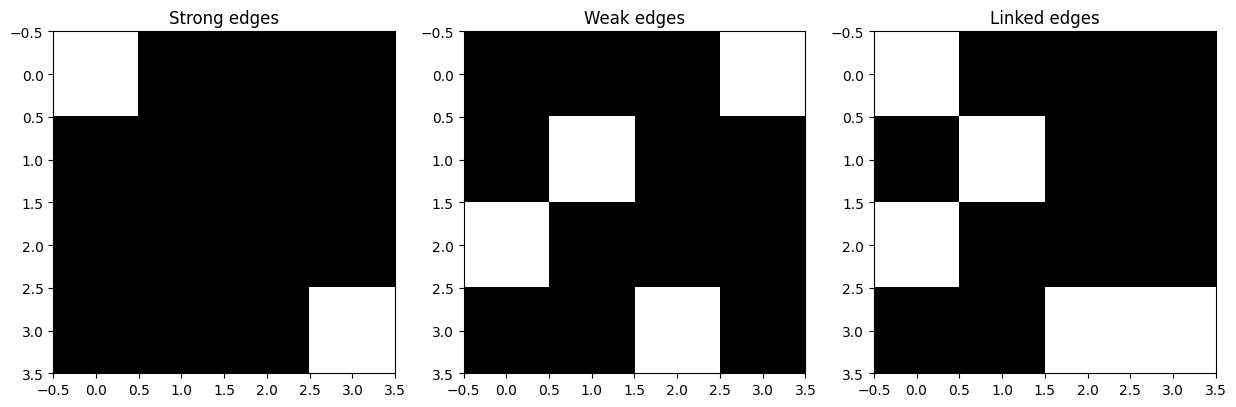

In [63]:

test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]],
    dtype=np.bool
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]],
    dtype=np.bool
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

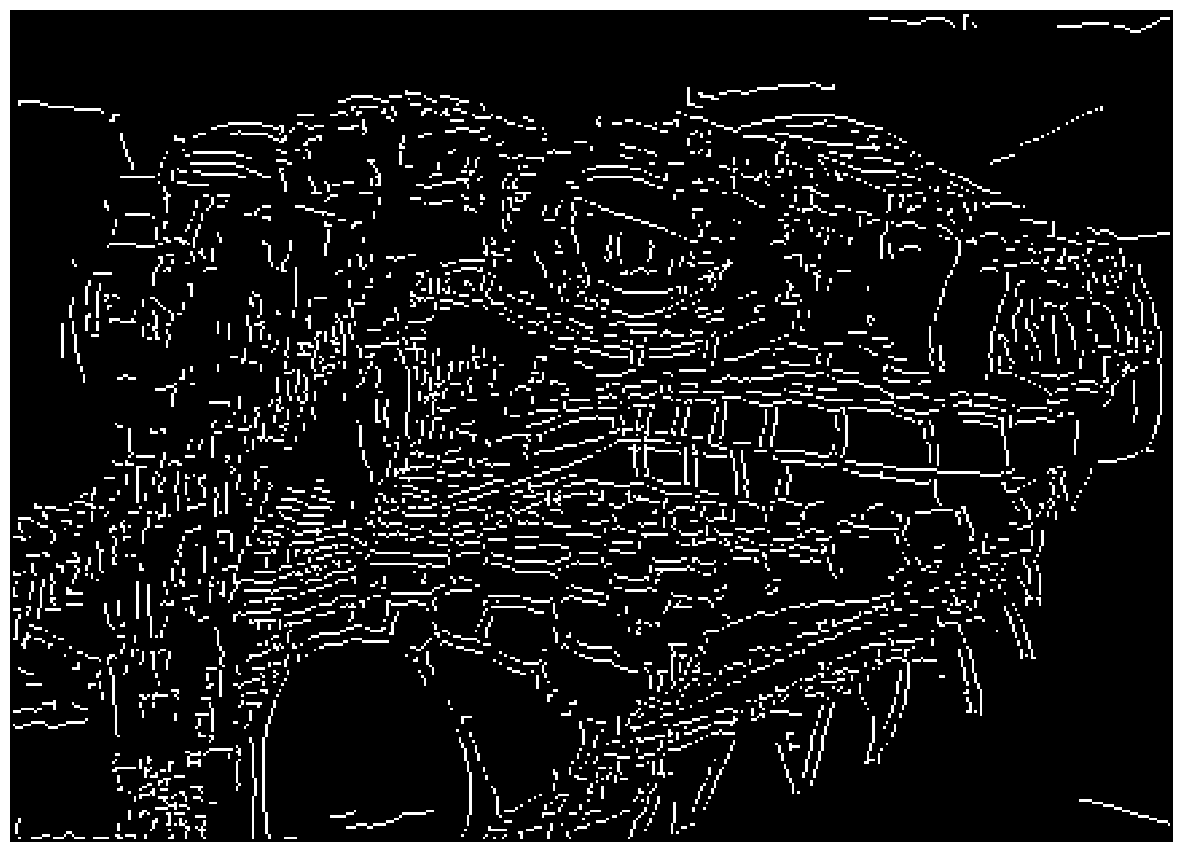

In [64]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

In [65]:
!apt-get update -qq
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!apt-get install -y pandoc
!pip install nbconvert

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [66]:
!jupyter nbconvert --to pdf "HW1.ipynb"

[NbConvertApp] Converting notebook HW1.ipynb to pdf
[NbConvertApp] Support files will be in HW1_files/
[NbConvertApp] Making directory ./HW1_files
[NbConvertApp] Writing 73373 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1471179 bytes to HW1.pdf
